**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


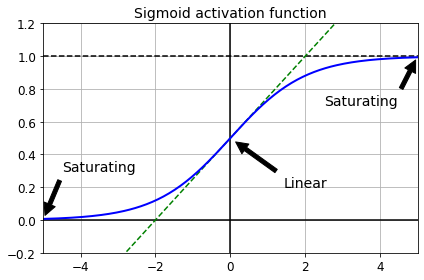

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


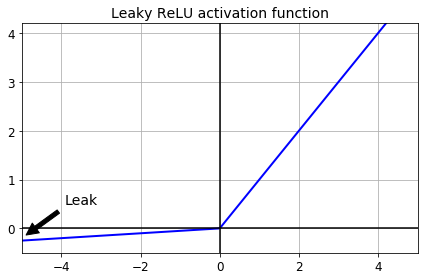

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [21]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=6,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/6
55000/55000 [==============================] - 26s 480us/sample - loss: 1.2806 - accuracy: 0.6250 - val_loss: 0.8883 - val_accuracy: 0.7152
Epoch 2/6
55000/55000 [==============================] - 23s 422us/sample - loss: 0.7954 - accuracy: 0.7372 - val_loss: 0.7135 - val_accuracy: 0.7648
Epoch 3/6
55000/55000 [==============================] - 21s 383us/sample - loss: 0.6816 - accuracy: 0.7727 - val_loss: 0.6356 - val_accuracy: 0.7882
Epoch 4/6
55000/55000 [==============================] - 26s 471us/sample - loss: 0.6215 - accuracy: 0.7936 - val_loss: 0.5922 - val_accuracy: 0.8006
Epoch 5/6
55000/55000 [==============================] - 23s 420us/sample - loss: 0.5830 - accuracy: 0.8082 - val_loss: 0.5596 - val_accuracy: 0.8172
Epoch 6/6
55000/55000 [==============================] - 22s 391us/sample - loss: 0.5553 - accuracy: 0.8155 - val_loss: 0.5339 - val_accuracy: 0.8238


Now let's try PReLU:

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=6,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/6
55000/55000 [==============================] - 25s 461us/sample - loss: 1.3470 - accuracy: 0.6225 - val_loss: 0.9268 - val_accuracy: 0.7200
Epoch 2/6
55000/55000 [==============================] - 27s 492us/sample - loss: 0.8209 - accuracy: 0.7357 - val_loss: 0.7322 - val_accuracy: 0.7640
Epoch 3/6
55000/55000 [==============================] - 24s 444us/sample - loss: 0.6972 - accuracy: 0.7697 - val_loss: 0.6494 - val_accuracy: 0.7866
Epoch 4/6
55000/55000 [==============================] - 23s 425us/sample - loss: 0.6332 - accuracy: 0.7904 - val_loss: 0.6027 - val_accuracy: 0.8026
Epoch 5/6
55000/55000 [==============================] - 26s 477us/sample - loss: 0.5918 - accuracy: 0.8050 - val_loss: 0.5675 - val_accuracy: 0.8140
Epoch 6/6
55000/55000 [==============================] - 27s 485us/sample - loss: 0.5619 - accuracy: 0.8140 - val_loss: 0.5393 - val_accuracy: 0.8250


### ELU

In [18]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


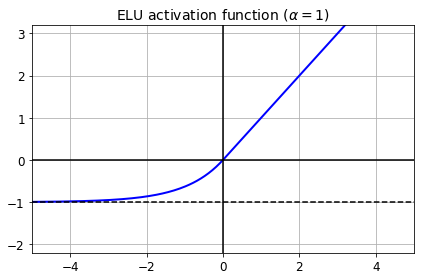

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [20]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [21]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


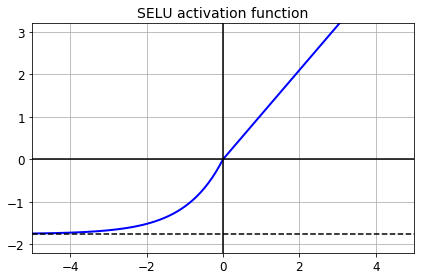

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [24]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [25]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [22]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [30]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 35s 644us/sample - loss: 1.0197 - accuracy: 0.6154 - val_loss: 0.7386 - val_accuracy: 0.7348
Epoch 2/5
55000/55000 [==============================] - 33s 607us/sample - loss: 0.7149 - accuracy: 0.7401 - val_loss: 0.6187 - val_accuracy: 0.7774
Epoch 3/5
55000/55000 [==============================] - 32s 583us/sample - loss: 0.6193 - accuracy: 0.7803 - val_loss: 0.5926 - val_accuracy: 0.8036
Epoch 4/5
55000/55000 [==============================] - 32s 586us/sample - loss: 0.5555 - accuracy: 0.8043 - val_loss: 0.5208 - val_accuracy: 0.8262
Epoch 5/5
55000/55000 [==============================] - 32s 573us/sample - loss: 0.5159 - accuracy: 0.8238 - val_loss: 0.4790 - val_accuracy: 0.8358


Now look at what happens if we try to use the ReLU activation function instead:

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 18s 319us/sample - loss: 1.9174 - accuracy: 0.2242 - val_loss: 1.3856 - val_accuracy: 0.3846
Epoch 2/5
55000/55000 [==============================] - 15s 279us/sample - loss: 1.2147 - accuracy: 0.4750 - val_loss: 1.0691 - val_accuracy: 0.5510
Epoch 3/5
55000/55000 [==============================] - 15s 281us/sample - loss: 0.9576 - accuracy: 0.6025 - val_loss: 0.7688 - val_accuracy: 0.7036
Epoch 4/5
55000/55000 [==============================] - 15s 281us/sample - loss: 0.8116 - accuracy: 0.6762 - val_loss: 0.7276 - val_accuracy: 0.7288
Epoch 5/5
55000/55000 [==============================] - 15s 278us/sample - loss: 0.8167 - accuracy: 0.6862 - val_loss: 0.7697 - val_accuracy: 0.7032


Not great at all, we suffered from the vanishing/exploding gradients problem.

# Batch Normalization

In [35]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_v2 (Batc (None, 784)               3136      
_________________________________________________________________
dense_210 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 300)               1200      
_________________________________________________________________
dense_211 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, 100)               400       
_________________________________________________________________
dense_212 (Dense)            (None, 10)               

In [37]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization_v2/gamma:0', True),
 ('batch_normalization_v2/beta:0', True),
 ('batch_normalization_v2/moving_mean:0', False),
 ('batch_normalization_v2/moving_variance:0', False)]

In [38]:
bn1.updates

ListWrapper([<tf.Operation 'batch_normalization_v2/cond_2/Identity' type=Identity>, <tf.Operation 'batch_normalization_v2/cond_3/Identity' type=Identity>])

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.8756 - accuracy: 0.7140 - val_loss: 0.5514 - val_accuracy: 0.8212
Epoch 2/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5765 - accuracy: 0.8033 - val_loss: 0.4742 - val_accuracy: 0.8436
Epoch 3/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.5146 - accuracy: 0.8216 - val_loss: 0.4382 - val_accuracy: 0.8530
Epoch 4/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.4821 - accuracy: 0.8322 - val_loss: 0.4170 - val_accuracy: 0.8604
Epoch 5/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.4589 - accuracy: 0.8402 - val_loss: 0.4003 - val_accuracy: 0.8658
Epoch 6/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.4428 - accuracy: 0.8459 - val_loss: 0.3883 - val_accuracy: 0.8698
Epoch 7/10
55000/55000 [==============================] -

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [42]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [43]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 89us/sample - loss: 0.8617 - accuracy: 0.7095 - val_loss: 0.5649 - val_accuracy: 0.8102
Epoch 2/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.5803 - accuracy: 0.8015 - val_loss: 0.4833 - val_accuracy: 0.8344
Epoch 3/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.5153 - accuracy: 0.8208 - val_loss: 0.4463 - val_accuracy: 0.8462
Epoch 4/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.4846 - accuracy: 0.8307 - val_loss: 0.4256 - val_accuracy: 0.8530
Epoch 5/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.4576 - accuracy: 0.8402 - val_loss: 0.4106 - val_accuracy: 0.8590
Epoch 6/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.4401 - accuracy: 0.8467 - val_loss: 0.3973 - val_accuracy: 0.8610
Epoch 7/10
55000/55000 [==============================] -

## Gradient Clipping

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [44]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [45]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [46]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [47]:
X_train_A.shape

(43986, 28, 28)

In [48]:
X_train_B.shape

(200, 28, 28)

In [49]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [50]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [51]:
tf.random.set_seed(42)
np.random.seed(42)

In [52]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [53]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [54]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 3s 78us/sample - loss: 0.5887 - accuracy: 0.8123 - val_loss: 0.3749 - val_accuracy: 0.8734
Epoch 2/20
43986/43986 [==============================] - 3s 69us/sample - loss: 0.3516 - accuracy: 0.8793 - val_loss: 0.3223 - val_accuracy: 0.8874
Epoch 3/20
43986/43986 [==============================] - 3s 68us/sample - loss: 0.3160 - accuracy: 0.8894 - val_loss: 0.3009 - val_accuracy: 0.8956
Epoch 4/20
43986/43986 [==============================] - 3s 70us/sample - loss: 0.2963 - accuracy: 0.8979 - val_loss: 0.2850 - val_accuracy: 0.9036
Epoch 5/20
43986/43986 [==============================] - 3s 68us/sample - loss: 0.2825 - accuracy: 0.9035 - val_loss: 0.2767 - val_accuracy: 0.9076
Epoch 6/20
43986/43986 [==============================] - 3s 69us/sample - loss: 0.2720 - accuracy: 0.9068 - val_loss: 0.2672 - val_accuracy: 0.9093
Epoch 7/20
43986/43986 [==============================] -

In [55]:
model_A.save("my_model_A.h5")

In [56]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [57]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [58]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 0s 2ms/sample - loss: 0.9537 - accuracy: 0.4800 - val_loss: 0.6472 - val_accuracy: 0.5710
Epoch 2/20
200/200 [==============================] - 0s 318us/sample - loss: 0.5805 - accuracy: 0.6850 - val_loss: 0.4863 - val_accuracy: 0.8428
Epoch 3/20
200/200 [==============================] - 0s 318us/sample - loss: 0.4561 - accuracy: 0.8750 - val_loss: 0.4116 - val_accuracy: 0.8905
Epoch 4/20
200/200 [==============================] - 0s 308us/sample - loss: 0.3885 - accuracy: 0.9100 - val_loss: 0.3650 - val_accuracy: 0.9148
Epoch 5/20
200/200 [==============================] - 0s 311us/sample - loss: 0.3426 - accuracy: 0.9250 - val_loss: 0.3308 - val_accuracy: 0.9270
Epoch 6/20
200/200 [==============================] - 0s 317us/sample - loss: 0.3084 - accuracy: 0.9300 - val_loss: 0.3044 - val_accuracy: 0.9371
Epoch 7/20
200/200 [==============================] - 0s 309us/sample - loss: 0.

In [59]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_v2_3 (Ba (None, 784)               3136      
_________________________________________________________________
dense_213 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_v2_4 (Ba (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_214 (Dense)            (None, 100)               30100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)              

In [60]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [61]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [62]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [63]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 0s 2ms/sample - loss: 0.5851 - accuracy: 0.6600 - val_loss: 0.5855 - val_accuracy: 0.6318
Epoch 2/4
200/200 [==============================] - 0s 303us/sample - loss: 0.5484 - accuracy: 0.6850 - val_loss: 0.5484 - val_accuracy: 0.6775
Epoch 3/4
200/200 [==============================] - 0s 294us/sample - loss: 0.5116 - accuracy: 0.7250 - val_loss: 0.5141 - val_accuracy: 0.7160
Epoch 4/4
200/200 [==============================] - 0s 316us/sample - loss: 0.4779 - accuracy: 0.7450 - val_loss: 0.4859 - val_accuracy: 0.7363
Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 0s 2ms/sample - loss: 0.3989 - accuracy: 0.8050 - val_loss: 0.3419 - val_accuracy: 0.8702
Epoch 2/16
200/200 [==============================] - 0s 328us/sample - loss: 0.2795 - accuracy: 0.9300 - val_loss: 0.2624 - val_accuracy: 0.9280
Epoch 3/16
200/200 [====================

So, what's the final verdict?

In [64]:
model_B.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 41us/sample - loss: 0.1431 - accuracy: 0.9705


[0.1430660070180893, 0.9705]

In [65]:
model_B_on_A.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 38us/sample - loss: 0.0689 - accuracy: 0.9925


[0.06887910133600235, 0.9925]

Great! We got quite a bit of transfer: the error rate dropped by a factor of almost 4!

In [66]:
(100 - 97.05) / (100 - 99.25)

3.933333333333337

# Faster Optimizers

## Momentum optimization

In [67]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

In [68]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [69]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

## RMSProp

In [70]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## Adam Optimization

In [71]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Adamax Optimization

In [72]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

In [73]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [74]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [75]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [76]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 66us/sample - loss: 0.4840 - accuracy: 0.8296 - val_loss: 0.4038 - val_accuracy: 0.8630
Epoch 2/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.3787 - accuracy: 0.8653 - val_loss: 0.3846 - val_accuracy: 0.8706
Epoch 3/25
55000/55000 [==============================] - 3s 62us/sample - loss: 0.3461 - accuracy: 0.8770 - val_loss: 0.3606 - val_accuracy: 0.8776
Epoch 4/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.3248 - accuracy: 0.8844 - val_loss: 0.3661 - val_accuracy: 0.8738
Epoch 5/25
55000/55000 [==============================] - 3s 62us/sample - loss: 0.3092 - accuracy: 0.8902 - val_loss: 0.3516 - val_accuracy: 0.8792
Epoch 6/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.2967 - accuracy: 0.8938 - val_loss: 0.3467 - val_accuracy: 0.8810
Epoch 7/25
55000/55000 [==============================] -

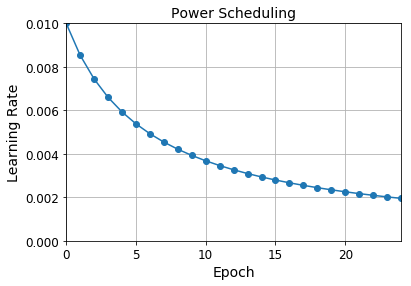

In [77]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [78]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [79]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [80]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [81]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 107us/sample - loss: 0.8245 - accuracy: 0.7595 - val_loss: 1.0870 - val_accuracy: 0.7106
Epoch 2/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.6391 - accuracy: 0.8064 - val_loss: 0.6125 - val_accuracy: 0.8160
Epoch 3/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.5962 - accuracy: 0.8174 - val_loss: 0.6526 - val_accuracy: 0.8086
Epoch 4/25
55000/55000 [==============================] - 5s 99us/sample - loss: 0.5420 - accuracy: 0.8306 - val_loss: 0.7521 - val_accuracy: 0.7766
Epoch 5/25
55000/55000 [==============================] - 5s 100us/sample - loss: 0.4853 - accuracy: 0.8460 - val_loss: 0.5616 - val_accuracy: 0.8314
Epoch 6/25
55000/55000 [==============================] - 5s 98us/sample - loss: 0.4443 - accuracy: 0.8571 - val_loss: 0.5430 - val_accuracy: 0.8664
Epoch 7/25
55000/55000 [=============================

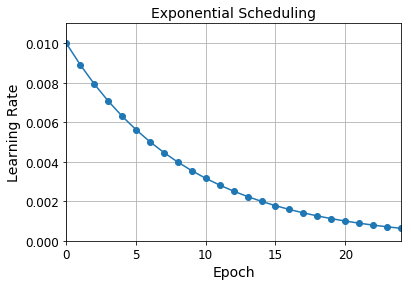

In [82]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [83]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [84]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 7s 132us/sample - loss: 0.8067 - accuracy: 0.7678 - val_loss: 0.7942 - val_accuracy: 0.7780
Epoch 2/25
55000/55000 [==============================] - 7s 122us/sample - loss: 0.6784 - accuracy: 0.7937 - val_loss: 0.8375 - val_accuracy: 0.8120
Epoch 3/25
55000/55000 [==============================] - 6s 114us/sample - loss: 0.6060 - accuracy: 0.8148 - val_loss: 0.6303 - val_accuracy: 0.8304
Epoch 4/25
55000/55000 [==============================] - 6s 114us/sample - loss: 0.5279 - accuracy: 0.8341 - val_loss: 0.5724 - val_accuracy: 0.8196
Epoch 5/25
55000/55000 [==============================] - 6s 112us/sample - loss: 0.4803 - accuracy: 0.8486 - val_loss: 0.5488 - val_accuracy: 0.8486
Epoch 6/25
55000/55000 [==============================] - 6s 113us/sample - loss: 0.4305 - accuracy: 0.8611 - val_loss: 0.4778 - val_accuracy: 0.8470
Epoch 7/25
55000/55000 [===========================

In [85]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

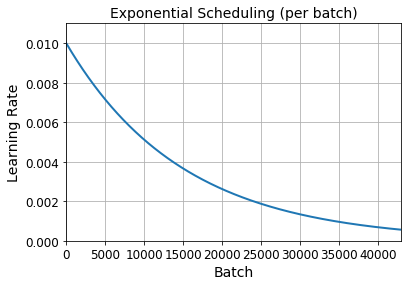

In [86]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [87]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [88]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [89]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 111us/sample - loss: 0.8151 - accuracy: 0.7655 - val_loss: 0.6868 - val_accuracy: 0.7780
Epoch 2/25
55000/55000 [==============================] - 6s 102us/sample - loss: 0.8153 - accuracy: 0.7659 - val_loss: 1.0604 - val_accuracy: 0.7148
Epoch 3/25
55000/55000 [==============================] - 6s 104us/sample - loss: 0.9138 - accuracy: 0.7218 - val_loss: 1.3223 - val_accuracy: 0.6660
Epoch 4/25
55000/55000 [==============================] - 6s 103us/sample - loss: 0.8506 - accuracy: 0.7627 - val_loss: 0.6807 - val_accuracy: 0.8174
Epoch 5/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.7213 - accuracy: 0.8068 - val_loss: 1.0441 - val_accuracy: 0.8030
Epoch 6/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.4882 - accuracy: 0.8548 - val_loss: 0.5411 - val_accuracy: 0.8494
Epoch 7/25
55000/55000 [===========================

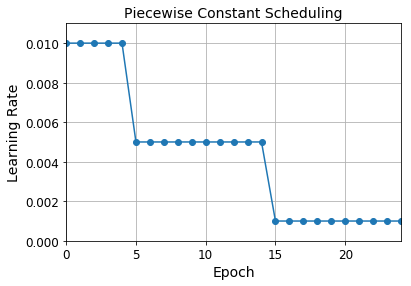

In [90]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [91]:
tf.random.set_seed(42)
np.random.seed(42)

In [92]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 79us/sample - loss: 0.5954 - accuracy: 0.8055 - val_loss: 0.5432 - val_accuracy: 0.8154
Epoch 2/25
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5194 - accuracy: 0.8345 - val_loss: 0.5184 - val_accuracy: 0.8468
Epoch 3/25
55000/55000 [==============================] - 4s 73us/sample - loss: 0.5080 - accuracy: 0.8453 - val_loss: 0.5780 - val_accuracy: 0.8384
Epoch 4/25
55000/55000 [==============================] - 4s 73us/sample - loss: 0.5360 - accuracy: 0.8452 - val_loss: 0.7195 - val_accuracy: 0.8350
Epoch 5/25
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5239 - accuracy: 0.8504 - val_loss: 0.5219 - val_accuracy: 0.8562
Epoch 6/25
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5163 - accuracy: 0.8528 - val_loss: 0.5669 - val_accuracy: 0.8382
Epoch 7/25
55000/55000 [==============================] -

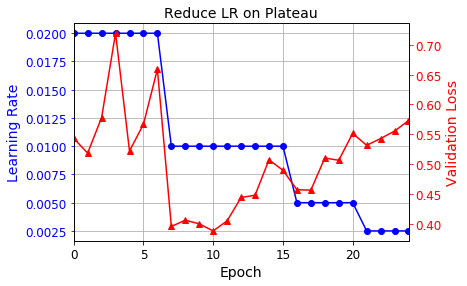

In [93]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [94]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 77us/sample - loss: 0.4887 - accuracy: 0.8282 - val_loss: 0.4245 - val_accuracy: 0.8526
Epoch 2/25
55000/55000 [==============================] - 4s 71us/sample - loss: 0.3830 - accuracy: 0.8641 - val_loss: 0.3798 - val_accuracy: 0.8688
Epoch 3/25
55000/55000 [==============================] - 4s 71us/sample - loss: 0.3491 - accuracy: 0.8758 - val_loss: 0.3650 - val_accuracy: 0.8730
Epoch 4/25
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3267 - accuracy: 0.8839 - val_loss: 0.3564 - val_accuracy: 0.8746
Epoch 5/25
55000/55000 [==============================] - 4s 72us/sample - loss: 0.3102 - accuracy: 0.8893 - val_loss: 0.3493 - val_accuracy: 0.8770
Epoch 6/25
55000/55000 [==============================] - 4s 73us/sample - loss: 0.2969 - accuracy: 0.8939 - val_loss: 0.3400 - val_accuracy: 0.8818
Epoch 7/25
55000/55000 [==============================] -

For piecewise constant scheduling, try this:

In [95]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

In [96]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [97]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Train on 55000 samples
55000/55000 [==============================] - 2s 28us/sample - loss: nan - accuracy: 0.3888


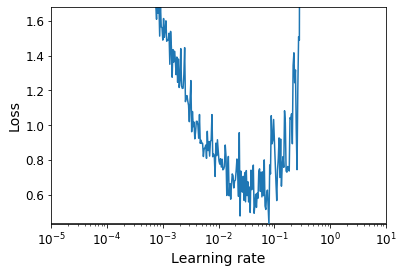

In [98]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [99]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [100]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 1s 23us/sample - loss: 0.6569 - accuracy: 0.7750 - val_loss: 0.4875 - val_accuracy: 0.8300
Epoch 2/25
55000/55000 [==============================] - 1s 22us/sample - loss: 0.4584 - accuracy: 0.8391 - val_loss: 0.4390 - val_accuracy: 0.8476
Epoch 3/25
55000/55000 [==============================] - 1s 21us/sample - loss: 0.4124 - accuracy: 0.8541 - val_loss: 0.4102 - val_accuracy: 0.8570
Epoch 4/25
55000/55000 [==============================] - 1s 22us/sample - loss: 0.3842 - accuracy: 0.8643 - val_loss: 0.3893 - val_accuracy: 0.8652
Epoch 5/25
55000/55000 [==============================] - 1s 21us/sample - loss: 0.3641 - accuracy: 0.8707 - val_loss: 0.3736 - val_accuracy: 0.8678
Epoch 6/25
55000/55000 [==============================] - 1s 22us/sample - loss: 0.3456 - accuracy: 0.8781 - val_loss: 0.3652 - val_accuracy: 0.8726
Epoch 7/25
55000/55000 [==============================] -

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [101]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [102]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 128us/sample - loss: 1.6073 - accuracy: 0.8112 - val_loss: 0.7314 - val_accuracy: 0.8242
Epoch 2/2
55000/55000 [==============================] - 6s 117us/sample - loss: 0.7193 - accuracy: 0.8256 - val_loss: 0.7029 - val_accuracy: 0.8304


In [103]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 129us/sample - loss: 1.6597 - accuracy: 0.8128 - val_loss: 0.7630 - val_accuracy: 0.8080
Epoch 2/2
55000/55000 [==============================] - 7s 124us/sample - loss: 0.7176 - accuracy: 0.8271 - val_loss: 0.6848 - val_accuracy: 0.8360


## Dropout

In [104]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 8s 145us/sample - loss: 0.5741 - accuracy: 0.8030 - val_loss: 0.3841 - val_accuracy: 0.8572
Epoch 2/2
55000/55000 [==============================] - 7s 134us/sample - loss: 0.4218 - accuracy: 0.8469 - val_loss: 0.3534 - val_accuracy: 0.8728


## Alpha Dropout

In [105]:
tf.random.set_seed(42)
np.random.seed(42)

In [106]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 6s 111us/sample - loss: 0.6639 - accuracy: 0.7582 - val_loss: 0.5840 - val_accuracy: 0.8410
Epoch 2/20
55000/55000 [==============================] - 5s 97us/sample - loss: 0.5517 - accuracy: 0.7968 - val_loss: 0.5747 - val_accuracy: 0.8430
Epoch 3/20
55000/55000 [==============================] - 5s 94us/sample - loss: 0.5260 - accuracy: 0.8062 - val_loss: 0.5233 - val_accuracy: 0.8486
Epoch 4/20
55000/55000 [==============================] - 5s 94us/sample - loss: 0.5055 - accuracy: 0.8136 - val_loss: 0.4687 - val_accuracy: 0.8606
Epoch 5/20
55000/55000 [==============================] - 5s 96us/sample - loss: 0.4897 - accuracy: 0.8187 - val_loss: 0.5188 - val_accuracy: 0.8588
Epoch 6/20
55000/55000 [==============================] - 5s 93us/sample - loss: 0.4812 - accuracy: 0.8217 - val_loss: 0.4929 - val_accuracy: 0.8508
Epoch 7/20
55000/55000 [==============================] 

In [107]:
model.evaluate(X_test_scaled, y_test)

10000/10000 [==============================] - 0s 39us/sample - loss: 0.4535 - accuracy: 0.8680


[0.45350628316402436, 0.868]

In [108]:
model.evaluate(X_train_scaled, y_train)

55000/55000 [==============================] - 2s 41us/sample - loss: 0.3357 - accuracy: 0.8887


[0.335701530437036, 0.88872725]

In [109]:
history = model.fit(X_train_scaled, y_train)

## MC Dropout

In [110]:
tf.random.set_seed(42)
np.random.seed(42)

In [111]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [112]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

In [113]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0

In [114]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

In [115]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [116]:
y_pred = np.argmax(y_proba, axis=1)

In [117]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.868

In [118]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [119]:
tf.random.set_seed(42)
np.random.seed(42)

In [120]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [121]:
mc_model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_33 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout_3 (MCAlphaD (None, 784)               0         
_________________________________________________________________
dense_311 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_4 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_312 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_5 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_313 (Dense)            (None, 10)              

In [122]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [123]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [124]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.19, 0.  , 0.64]],
      dtype=float32)

## Max norm

In [125]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [126]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 8s 147us/sample - loss: 0.4745 - accuracy: 0.8329 - val_loss: 0.3988 - val_accuracy: 0.8584
Epoch 2/2
55000/55000 [==============================] - 7s 135us/sample - loss: 0.3554 - accuracy: 0.8688 - val_loss: 0.3681 - val_accuracy: 0.8726


# Exercises

## 1. to 7.

See appendix A.

## 8. Deep Learning

### 8.1.

_Exercise: Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function._

In [19]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100,activation='elu'),
    keras.layers.Dense(100,activation='elu'),
    keras.layers.Dense(100,activation='elu'),
    keras.layers.Dense(100,activation='elu'),
    keras.layers.Dense(100,activation='elu'),
    keras.layers.Dense(10, activation="softmax")
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [24]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 4
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/4
55000/55000 [==============================] - 32s 574us/sample - loss: 0.4440 - accuracy: 0.8378 - val_loss: 0.3685 - val_accuracy: 0.8650
Epoch 2/4
55000/55000 [==============================] - 31s 561us/sample - loss: 0.3362 - accuracy: 0.8760 - val_loss: 0.3417 - val_accuracy: 0.8734
Epoch 3/4
55000/55000 [==============================] - 27s 495us/sample - loss: 0.2982 - accuracy: 0.8892 - val_loss: 0.3431 - val_accuracy: 0.8776
Epoch 4/4
55000/55000 [==============================] - 28s 500us/sample - loss: 0.2754 - accuracy: 0.8971 - val_loss: 0.3264 - val_accuracy: 0.8838


### 8.2.

_Exercise: Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later._

In [25]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
def split_dataset(X, y):
    y_0_to_4 = (y == 0) | (y == 1) | (y==2) | (y==3) | (y==4) # ) 0 To 4
    y_A = (y[y_0_to_4]).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return (X[y_0_to_4], y_A)


(X_train_A, y_train_A) = split_dataset(X_train, y_train)
(X_test_A, y_test_A) = split_dataset(X_test, y_test)
(X_valid_A, y_valid_A) = split_dataset(X_valid, y_valid)

In [26]:
X_train_A[1]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.17254902, 0.21568627, 0.37647059,
        0.78823529, 0.1372549 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.23529412, 0.72156863, 0.20784314,
        0.19607843, 0.06666667, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.35686275, 0.40784314, 0.3254902 , 0.17254902,
        0.70196078, 0.95294118, 0.83921569, 0.61176471, 0.58039216,
        0.83137255, 0.97254902, 1.        , 0.72156863, 0.15686275,
        0.3372549 , 0.42745098, 0.30588235, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.29411765, 0.55686275, 0.19607843, 0.29411765, 0.23529412,
        0.08235294, 0.38431373, 0.83137255, 0.8745098 , 0.73333333,
        0.90980392, 0.8313

In [34]:
(y_train_A == 6).sum()

0

In [40]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100,activation='elu'),
    keras.layers.Dense(100,activation='elu'),
    keras.layers.Dense(100,activation='elu'),
    keras.layers.Dense(100,activation='elu'),
    keras.layers.Dense(100,activation='elu'),
    keras.layers.Dense(5, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_model.h5", save_weights_only=True,save_freq=1) # it save after 2 epochs
n_epochs = 4
history = model.fit(X_train_A, y_train_A, epochs=n_epochs,
                    validation_data=(X_valid_A, y_valid_A),
                   callbacks=[checkpoint_cb])

Train on 27494 samples, validate on 2506 samples
Epoch 1/4
27494/27494 [==============================] - 39s 1ms/sample - loss: 0.3919 - accuracy: 0.8563 - val_loss: 0.3078 - val_accuracy: 0.8871
Epoch 2/4
27494/27494 [==============================] - 36s 1ms/sample - loss: 0.3098 - accuracy: 0.8848 - val_loss: 0.2910 - val_accuracy: 0.8891
Epoch 3/4
27494/27494 [==============================] - 41s 2ms/sample - loss: 0.2821 - accuracy: 0.8964 - val_loss: 0.2932 - val_accuracy: 0.8974
Epoch 4/4
23424/27494 [========================>.....] - ETA: 4s - loss: 0.2708 - accuracy: 0.8999

### 8.3.

_Exercise: Tune the hyperparameters using cross-validation and see what precision you can achieve._

In [151]:
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
import os

In [167]:
kf = KFold(5,shuffle=True,random_state=44)
(X_train, y_train),(X_test, y_test)= keras.datasets.fashion_mnist.load_data()
X_train_full, y_train_full = np.array(list(X_train) + list(X_test)), np.array(list(y_train) + list(y_test))
X_train_full = zscore(X_train_full)
# print(X_train_full.shape,y_train_full.shape)  shape become (70000, 28, 28) (70000,)

In [168]:
run_index = 1 # increment this at every run
run_logdir3 = os.path.join(os.curdir, "mnist_ex", "run_{:03d}".format(run_index))
run_logdir3

'.\\mnist_ex\\run_001'

In [169]:
x = X_train_full
y = y_train_full
oos_y = []
oos_pred = []
fold = 0
for train , test in kf.split(x):
    fold += 1
    print(f"Fold # {fold}")
    x_train = x[train]
    Y_train = y[train]
    x_test = x[test]
    Y_test = y[test]

    model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
        ])
    model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=3)
    checkpoint_cb = keras.callbacks.ModelCheckpoint("model_ex.h5", save_best_only=True)
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir3)

    history = model.fit(x_train, Y_train, epochs=5,
                        validation_data=(x_test, Y_test),
                        callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb])
#     model = keras.models.load_model("model_ex.h5") # rollback to best model
    
    pred = model.predict(x_test)
    pred = pred.reshape(pred.shape[0],pred.shape[1])
    pred = pd.DataFrame(pred)
    pred = pred.apply(lambda x:np.argmax(x),axis=1)
#     pred = pred.map()
    oos_y.append(Y_test)
    oos_pred.append(pred)
    #Measure this fold RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,Y_test))
    print(f"Fold score (RMSE) : {score}")

    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print(f"Finel , out of sample (RMSE) : {score}") 

Fold # 1
Train on 56000 samples, validate on 14000 samples
Epoch 1/5
56000/56000 [==============================] - 34s 604us/sample - loss: 0.4400 - accuracy: 0.8407 - val_loss: 0.3802 - val_accuracy: 0.8626
Epoch 2/5
56000/56000 [==============================] - 32s 563us/sample - loss: 0.3355 - accuracy: 0.8765 - val_loss: 0.3622 - val_accuracy: 0.8676
Epoch 3/5
56000/56000 [==============================] - 33s 584us/sample - loss: 0.2976 - accuracy: 0.8895 - val_loss: 0.3445 - val_accuracy: 0.8772
Epoch 4/5
56000/56000 [==============================] - 35s 616us/sample - loss: 0.2711 - accuracy: 0.8982 - val_loss: 0.3420 - val_accuracy: 0.8796
Epoch 5/5
56000/56000 [==============================] - 34s 605us/sample - loss: 0.2545 - accuracy: 0.9044 - val_loss: 0.3375 - val_accuracy: 0.8841


C:\Users\Adeel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Fold score (RMSE) : 1.2039221616984097
Fold # 2
Train on 56000 samples, validate on 14000 samples
Epoch 1/5
56000/56000 [==============================] - 28s 491us/sample - loss: 0.4460 - accuracy: 0.8406 - val_loss: 0.3561 - val_accuracy: 0.8686
Epoch 2/5
56000/56000 [==============================] - 27s 477us/sample - loss: 0.3349 - accuracy: 0.8764 - val_loss: 0.3690 - val_accuracy: 0.8654
Epoch 3/5
56000/56000 [==============================] - 27s 486us/sample - loss: 0.3016 - accuracy: 0.8885 - val_loss: 0.3269 - val_accuracy: 0.8845
Epoch 4/5
56000/56000 [==============================] - 27s 477us/sample - loss: 0.2740 - accuracy: 0.8979 - val_loss: 0.3376 - val_accuracy: 0.8829
Epoch 5/5
56000/56000 [==============================] - 26s 472us/sample - loss: 0.2504 - accuracy: 0.9058 - val_loss: 0.3306 - val_accuracy: 0.8868


C:\Users\Adeel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Fold score (RMSE) : 1.252483247678102
Fold # 3
Train on 56000 samples, validate on 14000 samples
Epoch 1/5
56000/56000 [==============================] - 28s 492us/sample - loss: 0.4430 - accuracy: 0.8398 - val_loss: 0.3648 - val_accuracy: 0.8699
Epoch 2/5
56000/56000 [==============================] - 27s 489us/sample - loss: 0.3394 - accuracy: 0.8749 - val_loss: 0.3302 - val_accuracy: 0.8802
Epoch 3/5
56000/56000 [==============================] - 27s 486us/sample - loss: 0.3017 - accuracy: 0.8876 - val_loss: 0.3250 - val_accuracy: 0.8797
Epoch 4/5
56000/56000 [==============================] - 27s 484us/sample - loss: 0.2769 - accuracy: 0.8955 - val_loss: 0.3391 - val_accuracy: 0.8848
Epoch 5/5
56000/56000 [==============================] - 27s 476us/sample - loss: 0.2541 - accuracy: 0.9029 - val_loss: 0.3133 - val_accuracy: 0.8886


C:\Users\Adeel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Fold score (RMSE) : 1.2355738978882878
Fold # 4
Train on 56000 samples, validate on 14000 samples
Epoch 1/5
56000/56000 [==============================] - 29s 513us/sample - loss: 0.4452 - accuracy: 0.8401 - val_loss: 0.3811 - val_accuracy: 0.8632
Epoch 2/5
56000/56000 [==============================] - 27s 479us/sample - loss: 0.3371 - accuracy: 0.8756 - val_loss: 0.3408 - val_accuracy: 0.8729
Epoch 3/5
56000/56000 [==============================] - 27s 476us/sample - loss: 0.3003 - accuracy: 0.8882 - val_loss: 0.3218 - val_accuracy: 0.8822
Epoch 4/5
56000/56000 [==============================] - 27s 484us/sample - loss: 0.2728 - accuracy: 0.8984 - val_loss: 0.3271 - val_accuracy: 0.8826
Epoch 5/5
56000/56000 [==============================] - 27s 479us/sample - loss: 0.2494 - accuracy: 0.9078 - val_loss: 0.3248 - val_accuracy: 0.8881


C:\Users\Adeel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Fold score (RMSE) : 1.227948346982536
Fold # 5
Train on 56000 samples, validate on 14000 samples
Epoch 1/5
56000/56000 [==============================] - 30s 543us/sample - loss: 0.4460 - accuracy: 0.8399 - val_loss: 0.3624 - val_accuracy: 0.8671
Epoch 2/5
56000/56000 [==============================] - 27s 485us/sample - loss: 0.3346 - accuracy: 0.8757 - val_loss: 0.3512 - val_accuracy: 0.8687
Epoch 3/5
56000/56000 [==============================] - 27s 483us/sample - loss: 0.2988 - accuracy: 0.8890 - val_loss: 0.3440 - val_accuracy: 0.8764
Epoch 4/5
56000/56000 [==============================] - 27s 478us/sample - loss: 0.2720 - accuracy: 0.8980 - val_loss: 0.3395 - val_accuracy: 0.8777
Epoch 5/5
56000/56000 [==============================] - 28s 498us/sample - loss: 0.2530 - accuracy: 0.9044 - val_loss: 0.3322 - val_accuracy: 0.8854


C:\Users\Adeel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Fold score (RMSE) : 1.2527113451572611
Finel , out of sample (RMSE) : 1.2346601614556592


In [ ]:
!tensorboard --logdir=./mnist_ex --port=6000
# np.argmax(pred[i ,for i in range(len(pred))])

In [165]:
# pred = pred.map(for i in pred range(len(pred))np.argmax(i))
print(pred.shape)
# pred.shape[0]
pred = pred.reshape(pred.shape[0],pred.shape[1])
pred = pd.DataFrame(pred)
pred = pred.apply(lambda x:np.argmax(x),axis=1)
print(pred.shape)

(14000, 10)


C:\Users\Adeel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


(14000,)


In [137]:
pred[2]

5

In [143]:
Y_test.shape

(14000,)

In [156]:
pred = model.predict(x_test)
pred = pred.reshape(pred.shape[1],pred.shape[0])
pred = pd.DataFrame(pred)
pred = pred.apply(lambda x:np.argmax(x),axis=1)
pred.shape
#     pred = pred.map()

(10,)

### 8.4.

_Exercise: Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?_

In [170]:
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
import os

In [171]:
kf = KFold(5,shuffle=True,random_state=44)
(X_train, y_train),(X_test, y_test)= keras.datasets.fashion_mnist.load_data()
X_train_full, y_train_full = np.array(list(X_train) + list(X_test)), np.array(list(y_train) + list(y_test))
X_train_full = zscore(X_train_full)
# print(X_train_full.shape,y_train_full.shape)  shape become (70000, 28, 28) (70000,)

In [173]:
run_index = 1 # increment this at every run
run_logdir4 = os.path.join(os.curdir, "mnist_x", "run_{:03d}".format(run_index))
run_logdir4

'.\\mnist_x\\run_001'

In [176]:
x = X_train_full
y = y_train_full
oos_y = []
oos_pred = []
fold = 0
for train , test in kf.split(x):
    fold += 1
    print(f"Fold # {fold}")
    x_train = x[train]
    Y_train = y[train]
    x_test = x[test]
    Y_test = y[test]

    model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),    
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
        ])
    model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=3)
    checkpoint_cb = keras.callbacks.ModelCheckpoint("model_x.h5", save_best_only=True)
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir4)

    history = model.fit(x_train, Y_train, epochs=5,
                        validation_data=(x_test, Y_test),
                        callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb])
#     model = keras.models.load_model("model_ex.h5") # rollback to best model
    
    pred = model.predict(x_test)
    pred = pred.reshape(pred.shape[0],pred.shape[1])
    pred = pd.DataFrame(pred)
    pred = pred.apply(lambda x:np.argmax(x),axis=1)
#     pred = pred.map()
    oos_y.append(Y_test)
    oos_pred.append(pred)
    #Measure this fold RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,Y_test))
    print(f"Fold score (RMSE) : {score}")

    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print(f"Finel , out of sample (RMSE) : {score}") 

Fold # 1
Train on 56000 samples, validate on 14000 samples
Epoch 1/5
56000/56000 [==============================] - 31s 547us/sample - loss: 0.4489 - accuracy: 0.8367 - val_loss: 0.3556 - val_accuracy: 0.8686
Epoch 2/5
56000/56000 [==============================] - 31s 562us/sample - loss: 0.3415 - accuracy: 0.8742 - val_loss: 0.3526 - val_accuracy: 0.8718
Epoch 3/5
56000/56000 [==============================] - 33s 590us/sample - loss: 0.3072 - accuracy: 0.8861 - val_loss: 0.3364 - val_accuracy: 0.8788
Epoch 4/5
56000/56000 [==============================] - 33s 592us/sample - loss: 0.2786 - accuracy: 0.8956 - val_loss: 0.3138 - val_accuracy: 0.8880
Epoch 5/5
56000/56000 [==============================] - 34s 603us/sample - loss: 0.2618 - accuracy: 0.9015 - val_loss: 0.3172 - val_accuracy: 0.8899


C:\Users\Adeel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Fold score (RMSE) : 1.2023191874753678
Fold # 2
Train on 56000 samples, validate on 14000 samples
Epoch 1/5
56000/56000 [==============================] - 29s 515us/sample - loss: 0.4516 - accuracy: 0.8360 - val_loss: 0.3619 - val_accuracy: 0.8713
Epoch 2/5
56000/56000 [==============================] - 27s 486us/sample - loss: 0.3463 - accuracy: 0.8717 - val_loss: 0.3351 - val_accuracy: 0.8769
Epoch 3/5
56000/56000 [==============================] - 28s 497us/sample - loss: 0.3063 - accuracy: 0.8871 - val_loss: 0.3248 - val_accuracy: 0.8802
Epoch 4/5
56000/56000 [==============================] - 27s 480us/sample - loss: 0.2828 - accuracy: 0.8943 - val_loss: 0.3181 - val_accuracy: 0.8831
Epoch 5/5
56000/56000 [==============================] - 27s 479us/sample - loss: 0.2620 - accuracy: 0.9020 - val_loss: 0.3089 - val_accuracy: 0.8904


C:\Users\Adeel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Fold score (RMSE) : 1.218752289375139
Fold # 3
Train on 56000 samples, validate on 14000 samples
Epoch 1/5
56000/56000 [==============================] - 29s 511us/sample - loss: 0.4583 - accuracy: 0.8322 - val_loss: 0.3581 - val_accuracy: 0.8686
Epoch 2/5
56000/56000 [==============================] - 27s 478us/sample - loss: 0.3503 - accuracy: 0.8697 - val_loss: 0.3239 - val_accuracy: 0.8838
Epoch 3/5
56000/56000 [==============================] - 27s 487us/sample - loss: 0.3125 - accuracy: 0.8847 - val_loss: 0.3038 - val_accuracy: 0.8880
Epoch 4/5
56000/56000 [==============================] - 27s 483us/sample - loss: 0.2857 - accuracy: 0.8939 - val_loss: 0.3129 - val_accuracy: 0.8834
Epoch 5/5
56000/56000 [==============================] - 24s 432us/sample - loss: 0.2661 - accuracy: 0.9005 - val_loss: 0.3099 - val_accuracy: 0.8895


C:\Users\Adeel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Fold score (RMSE) : 1.211757873032869
Fold # 4
Train on 56000 samples, validate on 14000 samples
Epoch 1/5
56000/56000 [==============================] - 30s 533us/sample - loss: 0.4568 - accuracy: 0.8346 - val_loss: 0.3680 - val_accuracy: 0.8667
Epoch 2/5
56000/56000 [==============================] - 27s 485us/sample - loss: 0.3454 - accuracy: 0.8719 - val_loss: 0.3394 - val_accuracy: 0.8760
Epoch 3/5
56000/56000 [==============================] - 27s 481us/sample - loss: 0.3118 - accuracy: 0.8843 - val_loss: 0.3228 - val_accuracy: 0.8817
Epoch 4/5
56000/56000 [==============================] - 28s 506us/sample - loss: 0.2851 - accuracy: 0.8938 - val_loss: 0.3153 - val_accuracy: 0.8876
Epoch 5/5
56000/56000 [==============================] - 27s 480us/sample - loss: 0.2648 - accuracy: 0.9000 - val_loss: 0.3051 - val_accuracy: 0.8886


C:\Users\Adeel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Fold score (RMSE) : 1.256866852818661
Fold # 5
Train on 56000 samples, validate on 14000 samples
Epoch 1/5
56000/56000 [==============================] - 28s 509us/sample - loss: 0.4536 - accuracy: 0.8355 - val_loss: 0.3544 - val_accuracy: 0.8709
Epoch 2/5
56000/56000 [==============================] - 27s 473us/sample - loss: 0.3421 - accuracy: 0.8739 - val_loss: 0.3412 - val_accuracy: 0.8735
Epoch 3/5
56000/56000 [==============================] - 28s 496us/sample - loss: 0.3099 - accuracy: 0.8838 - val_loss: 0.3397 - val_accuracy: 0.8724
Epoch 4/5
56000/56000 [==============================] - 27s 476us/sample - loss: 0.2829 - accuracy: 0.8934 - val_loss: 0.3193 - val_accuracy: 0.8851
Epoch 5/5
56000/56000 [==============================] - 27s 478us/sample - loss: 0.2629 - accuracy: 0.9003 - val_loss: 0.3217 - val_accuracy: 0.8864


C:\Users\Adeel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Fold score (RMSE) : 1.2244532307465705
Finel , out of sample (RMSE) : 1.2229706222379761


### 8.5.

_Exercise: is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?_

## 9. Transfer learning

### 9.1.

_Exercise: create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one._

### 9.2.

_Exercise: train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?_

### 9.3.

_Exercise: try caching the frozen layers, and train the model again: how much faster is it now?_

### 9.4.

_Exercise: try again reusing just four hidden layers instead of five. Can you achieve a higher precision?_

### 9.5.

_Exercise: now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?_

## 10. Pretraining on an auxiliary task

In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data.

### 10.1.
Exercise: _Start by building two DNNs (let's call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add one more hidden layer with 10 units on top of both DNNs. You should use the `keras.layers.concatenate()` function to concatenate the outputs of both DNNs, then feed the result to the hidden layer. Finally, add an output layer with a single neuron using the logistic activation function._

### 10.2.
_Exercise: split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes._

### 10.3.
_Exercise: train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not._

### 10.4.
_Exercise: now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on top with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class._